In [ ]:
import random
import math
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
def spread(g): # input is gene
    if g>=0:
        return np.pi*(np.exp(-1*g) - 1/np.e)/(1-np.e**-1) # exp decay on both sides
    else:
        return np.pi*(np.exp(g) - 1/np.e)/(1-np.e**-1)

def center(g):
    return 0 if g>=0 else np.pi

def y(x, rm, ro, g):
    return (rm + 9*rm/10*(x-rm)/(rm-ro)) * np.abs(g) # ro maps to rm/10

In [ ]:
class Food:
    def __init__(self, x, y):
        self.x = x
        self.y = y

class Creature:
    def __init__(self, x, y, observation_radius, movement_radius, gene, energy=100):
        self.x = x
        self.y = y
        self.observation_radius = observation_radius
        self.movement_radius = movement_radius
        self.gene = gene  # [reaction_to_food, reaction_to_prey, reaction_to_predator]
        self.energy = energy
        self.alive = True
        self.food_eaten = 0
        self.reproduction_threshold = 3  # Number of food items needed to reproduce

    def distance(self, obj):
        return np.sqrt((self.x - obj.x)**2 + (self.y - obj.y)**2)

    def disp_vec(self, obj, obj_type):
        # print(self, obj)
        # obj_type can be 0, 1, 2 for food, prey and pred
        if obj.x - self.x == 0:
            theta = np.pi / 2
        # elif
        else:
            theta = np.arctan2(obj.y - self.y, obj.x - self.x)
        g = self.gene[obj_type]
        c = center(g)
        s = spread(g)
        del_theta = np.random.uniform(c - s, c+s)
        move_dist = y(self.distance(obj), self.movement_radius, self.observation_radius, g)
        new_th = theta + del_theta
        return np.array([move_dist*np.cos(new_th), move_dist*np.sin(new_th)]), np.array([c, s, del_theta, new_th]) * 180/np.pi



    def act(self, food_list, prey_list, predator_list):
        if not self.alive:
            return None

        res_vec = np.array([0., 0.])

        # Check for food in observation radius
        for food in food_list:
            if self.distance(food) <= self.observation_radius:
                res_vec += self.disp_vec(food, 0)[0]  # maybe make it a bit more efficient by putting if con in disp_vec

        # Check for prey in observation radius (prey behavior or predator)
        for prey in prey_list:
            if self.distance(prey) <= self.observation_radius and self != prey and prey.alive:
                res_vec += self.disp_vec(prey, 1)[0]

        # Check for predator in observation radius
        for predator in predator_list:
            if self.distance(predator) <= self.observation_radius and self != predator and predator.alive:
                res_vec += self.disp_vec(predator, 2)[0]

        res_mag = np.linalg.norm(res_vec) # for max speed limit
        if res_mag > self.movement_radius:
            res_vec *= self.movement_radius / res_mag
            # print("normed")

        self.x += res_vec[0]
        self.y += res_vec[1]

        # Lose energy for every move
        self.energy -= 1

        # If energy is 0, the creature dies
        if self.energy <= 0:
            self.alive = False

In [ ]:
prey = Creature(0 ,0, 10, 1, gene = [1, 0, -1])
food = Food(5 ,5)
b = [prey , food]

print(prey == b[1])
print(prey.disp_vec(food, 0))

False
(array([0.27781746, 0.27781746]), array([ 0.,  0.,  0., 45.]))


In [ ]:
class Prey(Creature):
    def __init__(self, x, y, observation_radius, movement_radius, gene):
        super().__init__(x, y, observation_radius, movement_radius, gene)

    def eat(self, food_list):
        if not self.alive:
            return None

        for food in food_list:
            if self.distance(food) <= self.movement_radius:  # Same position as food
                self.food_eaten += 1
                self.energy += 20
                food_list.remove(food)
                break

    def reproduce(self):
        if self.food_eaten >= self.reproduction_threshold:
            self.food_eaten = 0  # Reset after reproduction
            # Mutate gene slightly (add small random change)
            new_gene = [min(max(g + random.uniform(-0.1, 0.1), -1), 1) for g in self.gene]
            return Prey(self.x, self.y, self.observation_radius, self.movement_radius, new_gene)
        return None

class Predator(Creature):
    def __init__(self, x, y, observation_radius, movement_radius, gene):
        super().__init__(x, y, observation_radius, movement_radius, gene)

    def eat(self, prey_list):
        if not self.alive:
            return None

        for prey in prey_list:
            if self.distance(prey) < self.movement_radius and prey.alive:  # Same position as prey
                self.energy += 50
                prey.alive = False
                break

    def reproduce(self):
        if self.energy >= 150:  # Energy threshold for predator to reproduce
            self.energy -= 50  # Energy cost for reproduction
            # Mutate gene slightly
            new_gene = [min(max(g + random.uniform(-0.1, 0.1), -1), 1) for g in self.gene]
            return Predator(self.x, self.y, self.observation_radius, self.movement_radius, new_gene)
        return None

True True 2
True True 2
False True 2
False True 2
False True 2


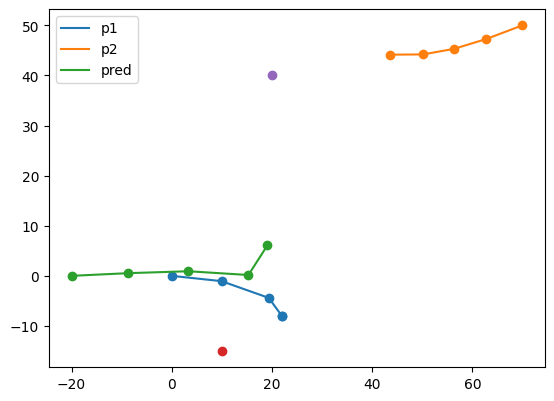

In [ ]:
p1 = Prey(0 ,0, 100, 10, gene = [1, 0, -1])
p2 = Prey(70 ,50, 100, 10, gene = [1, 0, -1])

f1 = Food(10, -15)
f2 = Food(20, 40)

pred = Predator(-20, 0, 100, 12, gene = [0, 1, 0])

foods = [f1, f2]
preys = [p1, p2]
preds=[pred]

xs, ys = [], []
xs2, ys2 = [], []
xsp, ysp = [], []

# pred.act(foods, preys, preds)
# print(pred.x, pred.y)

for _ in range(5):
    # plt.scatter(p1.x, p1.y)
    xs.append(p1.x)
    ys.append(p1.y)

    xs2.append(p2.x)
    ys2.append(p2.y)

    xsp.append(pred.x)
    ysp.append(pred.y)

    p1.act(foods, preys, preds)
    p2.act(foods, preys, preds)
    pred.act(foods, preys, preds)

    p1.eat(foods)
    p2.eat(foods)
    pred.eat(preys)
    print(p1.alive, p2.alive, len(foods))

plt.gca().set_aspect('equal')

plt.plot(xs, ys, label="p1")
plt.scatter(xs, ys)

plt.plot(xs2, ys2, label="p2")
plt.scatter(xs2, ys2)

plt.plot(xsp, ysp, label="pred")
plt.scatter(xsp, ysp)

plt.scatter(f1.x, f1.y)
plt.scatter(f2.x, f2.y)

plt.legend()

In [ ]:
def spawn_creatures(num_prey, num_predators, grid_size):
    prey_list = [Prey(random.uniform(-1*grid_size, grid_size), random.randint(-1*grid_size, grid_size),
                      observation_radius=10,
                      movement_radius = 1,
                      gene=[random.uniform(-1, 1) for _ in range(3)]) for _ in range(num_prey)]
    predator_list = [Predator(random.uniform(-1*grid_size, grid_size), random.uniform(-1*grid_size, grid_size),
                              observation_radius=10,
                              movement_radius = 1,
                              gene=[random.uniform(-1, 1) for _ in range(3)]) for _ in range(num_predators)]
    return prey_list, predator_list

def spawn_food(num_food, grid_size):
    return [Food(random.randint(0, grid_size-1), random.randint(0, grid_size-1)) for _ in range(num_food)]
